In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.optim import Optimizer, Adam
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy

import lightning as L

In [2]:
torch.set_float32_matmul_precision('high')

In [3]:
data_path = "data/NER dataset.csv"

In [4]:
df = pd.read_csv(data_path, encoding="unicode_escape")
df = df.rename(columns={"Sentence #": "Sentence"})

df = df.ffill()
df.head()

,Sentence,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [5]:
df["Sentence"] = df["Sentence"].str.split(":").str[1]

df.head()

,Sentence,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Sentence  1048575 non-null  object
 1   Word      1048575 non-null  object
 2   POS       1048575 non-null  object
 3   Tag       1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [7]:
df["Sentence"].value_counts()

Sentence
 22480    104
 33481     81
 40153     73
 21167     72
 21776     70
         ... 
 4810       2
 40249      2
 37093      2
 8412       1
 38917      1
Name: count, Length: 47959, dtype: int64

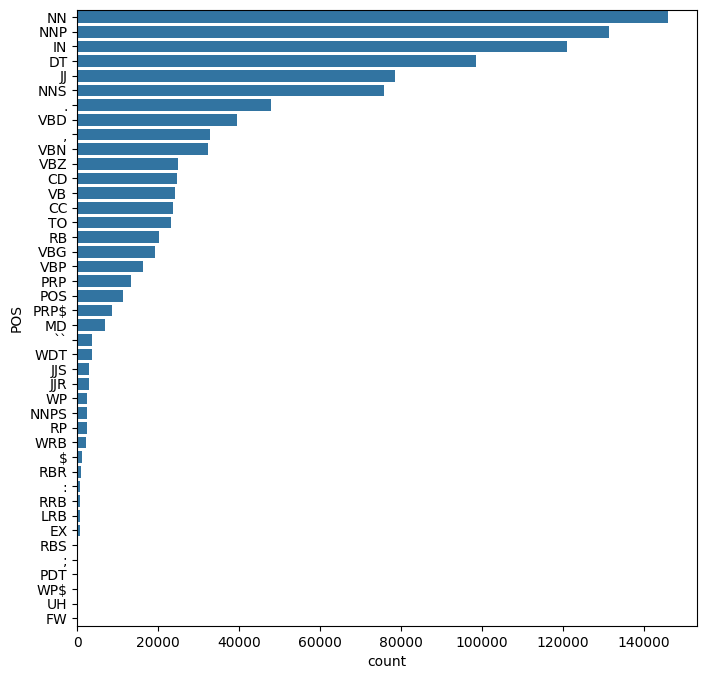

In [8]:
df_ = df["POS"].value_counts().reset_index()

plt.figure(figsize=(8, 8))
sns.barplot(y="POS", x="count", data=df_)
plt.show()

In [9]:
df["POS"].unique()

array(['NNS', 'IN', 'VBP', 'VBN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'CC',
       'JJ', '.', 'VBD', 'WP', '``', 'CD', 'PRP', 'VBZ', 'POS', 'VBG',
       'RB', ',', 'WRB', 'PRP$', 'MD', 'WDT', 'JJR', ':', 'JJS', 'WP$',
       'RP', 'PDT', 'NNPS', 'EX', 'RBS', 'LRB', 'RRB', '$', 'RBR', ';',
       'UH', 'FW'], dtype=object)

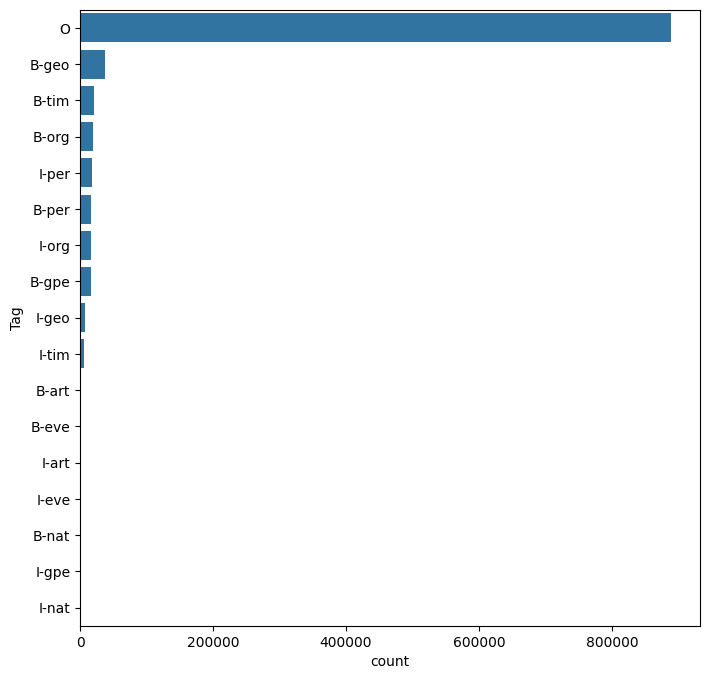

In [10]:
df_ = df["Tag"].value_counts().reset_index()

plt.figure(figsize=(8, 8))
sns.barplot(y="Tag", x="count", data=df_)
plt.show()

In [11]:
pos_encoder = LabelEncoder()
tag_encoder = LabelEncoder()

df["POS_encoded"] = pos_encoder.fit_transform(df["POS"])
df["Tag_encoded"] = tag_encoder.fit_transform(df["Tag"])

In [12]:
pos_pair = {k:v for v,k in enumerate(pos_encoder.classes_)}
print(pos_pair)

{'$': 0, ',': 1, '.': 2, ':': 3, ';': 4, 'CC': 5, 'CD': 6, 'DT': 7, 'EX': 8, 'FW': 9, 'IN': 10, 'JJ': 11, 'JJR': 12, 'JJS': 13, 'LRB': 14, 'MD': 15, 'NN': 16, 'NNP': 17, 'NNPS': 18, 'NNS': 19, 'PDT': 20, 'POS': 21, 'PRP': 22, 'PRP$': 23, 'RB': 24, 'RBR': 25, 'RBS': 26, 'RP': 27, 'RRB': 28, 'TO': 29, 'UH': 30, 'VB': 31, 'VBD': 32, 'VBG': 33, 'VBN': 34, 'VBP': 35, 'VBZ': 36, 'WDT': 37, 'WP': 38, 'WP$': 39, 'WRB': 40, '``': 41}


In [13]:
tag_pair = {k:v for v,k in enumerate(tag_encoder.classes_)}
print(tag_pair)

{'B-art': 0, 'B-eve': 1, 'B-geo': 2, 'B-gpe': 3, 'B-nat': 4, 'B-org': 5, 'B-per': 6, 'B-tim': 7, 'I-art': 8, 'I-eve': 9, 'I-geo': 10, 'I-gpe': 11, 'I-nat': 12, 'I-org': 13, 'I-per': 14, 'I-tim': 15, 'O': 16}


In [14]:
df.head(10)

,Sentence,Word,POS,Tag,POS_encoded,Tag_encoded
0,1,Thousands,NNS,O,19,16
1,1,of,IN,O,10,16
2,1,demonstrators,NNS,O,19,16
3,1,have,VBP,O,35,16
4,1,marched,VBN,O,34,16
5,1,through,IN,O,10,16
6,1,London,NNP,B-geo,17,2
7,1,to,TO,O,29,16
8,1,protest,VB,O,31,16
9,1,the,DT,O,7,16


In [15]:
df_ = df.groupby("Word")["POS"].apply(list).reset_index()
df_["POS"] = df_["POS"].apply(lambda x: set(x))
df_[df_["POS"].apply(lambda x: len(x) > 1)]

,Word,POS
7,&,"{NNP, CC}"
8,',"{POS, ``}"
17,'s,"{POS, PRP, VBZ, NNP}"
21,",","{,, CC}"
22,-,"{,, IN, LRB, RRB, NNP, :}"
...,...,...
35132,yen,"{NNS, NN}"
35138,yielded,"{VBN, VBD}"
35155,zero,"{CD, NN}"
35168,,"{,, :}"


In [16]:
data = []

for id, group in df.groupby("Sentence"):

    tokens = group["Word"].astype(str).tolist()
    pos = group["POS_encoded"].astype(int).tolist()
    tag = group["Tag_encoded"].astype(int).tolist()

    token_list = []
    for token, pos in zip(tokens, pos):
        token_list.append(f"{token}({pos})")

    data.append({
        "id": id,
        "final_tokens": token_list,
        "ner_outputs": tag
    })

In [17]:
data[0]

{'id': ' 1',
 'final_tokens': ['Thousands(19)',
  'of(10)',
  'demonstrators(19)',
  'have(35)',
  'marched(34)',
  'through(10)',
  'London(17)',
  'to(29)',
  'protest(31)',
  'the(7)',
  'war(16)',
  'in(10)',
  'Iraq(17)',
  'and(5)',
  'demand(31)',
  'the(7)',
  'withdrawal(16)',
  'of(10)',
  'British(11)',
  'troops(19)',
  'from(10)',
  'that(7)',
  'country(16)',
  '.(2)'],
 'ner_outputs': [16,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  3,
  16,
  16,
  16,
  16,
  16]}

In [18]:
sentences = []

for i in range(len(data)):
    words = data[i]["final_tokens"]

    for word in words:
        sentences.append(word)

print(len(sentences))
print(len(set(sentences)))

1048575
40623


In [19]:
def yield_tokens(data):
    for text in data:
        yield text.split()

# Building Vocab
def get_vocab(sentences):
    vocab = build_vocab_from_iterator(
        yield_tokens(sentences),
        specials = ['<unk>','<pad>'],
        special_first = True
    )
    vocab.set_default_index(vocab['<unk>'])
    
    return vocab

In [20]:
sentences[0]

'Thousands(19)'

In [21]:
vocab = get_vocab(sentences)

In [22]:
len(vocab)

40625

In [23]:
def sentences_to_ids(tokens):
    # tokens = sentence.split()
    indices = []

    for token in tokens:
        indices.append(vocab[token])

    return indices

In [24]:
for i in range(len(data)):
    list_token = sentences_to_ids(data[i]["final_tokens"])
    data[i]["final_tokens"] = list_token

In [25]:
data

[{'id': ' 1',
  'final_tokens': [1069,
   5,
   1120,
   19,
   5282,
   216,
   465,
   7,
   1075,
   2,
   151,
   6,
   59,
   9,
   2524,
   2,
   805,
   5,
   199,
   87,
   21,
   337,
   52,
   3],
  'ner_outputs': [16,
   16,
   16,
   16,
   16,
   16,
   2,
   16,
   16,
   16,
   16,
   16,
   2,
   16,
   16,
   16,
   16,
   16,
   3,
   16,
   16,
   16,
   16,
   16]},
 {'id': ' 10',
  'final_tokens': [304,
   41,
   25,
   55,
   2484,
   7,
   786,
   998,
   7,
   22185,
   3531,
   757,
   5,
   2,
   1177,
   82,
   4,
   44,
   27,
   1670,
   2307,
   459,
   2293,
   7494,
   3],
  'ner_outputs': [3,
   16,
   16,
   16,
   16,
   16,
   16,
   16,
   16,
   16,
   16,
   16,
   16,
   16,
   16,
   7,
   16,
   16,
   16,
   5,
   16,
   16,
   16,
   16,
   16]},
 {'id': ' 100',
  'final_tokens': [27179,
   5023,
   90,
   7582,
   359,
   5486,
   6,
   2,
   4749,
   833,
   126,
   4,
   167,
   282,
   460,
   103,
   28,
   783,
   7,
   180,
   2235,
  

In [26]:
batch_tokens = []
batch_target = []

for i in range(len(data)):
    token = torch.tensor(data[i]["final_tokens"], dtype=torch.long)
    target = torch.tensor(data[i]["ner_outputs"], dtype=torch.long)

    batch_tokens.append(token)
    batch_target.append(target)

In [27]:
batch_tokens = pad_sequence(batch_tokens, batch_first=True, padding_value=1)
batch_target = pad_sequence(batch_target, batch_first=True, padding_value=1)

print(batch_tokens.shape)
print(batch_target.shape)

torch.Size([47959, 104])
torch.Size([47959, 104])


In [28]:
train_size = int(0.8 * len(batch_tokens))
val_size = len(batch_tokens) - train_size

dataset = TensorDataset(batch_tokens, batch_target)

train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size]
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 38367
Validation set size: 9592


In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=11)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=11)

# model

In [30]:
class GruNER(nn.Module):
    def __init__(
        self, 
        vocab_size: int,
        hidden_size: int=128,
        embedding_size: int=256,
        bidirectional: int=0,
        num_classes: int=17
    ):
        super(GruNER, self).__init__()

        self.emb = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(
            embedding_size,
            hidden_size,
            num_layers = 2,
            bidirectional=True,
            batch_first=True
        )
        self.out_layer = nn.Linear(hidden_size * (bidirectional + 1), num_classes)

    def forward(self, x):
        x = self.emb(x)
        x, _ = self.gru(x)
        x = self.out_layer(x)
        return x

In [31]:
vocab_size = len(vocab)
hidden_size = 256
embed_size = 300

model = GruNER(
    vocab_size=vocab_size,
    embedding_size=embed_size,
    hidden_size=hidden_size,
    bidirectional=1
)

In [32]:
x, y = next(iter(train_loader))

print(x.shape)
print(y.shape)

torch.Size([32, 104])
torch.Size([32, 104])


In [33]:
pred = model(x)
pred.shape

torch.Size([32, 104, 17])

In [34]:
pred.view(-1, 17).shape

torch.Size([3328, 17])

In [35]:
y.view(-1).shape

torch.Size([3328])

In [36]:
pred_max = F.softmax(pred.view(-1, 17), dim=-1).max(dim=1)[1]
pred_max.shape

torch.Size([3328])

In [37]:
class GruTrainer(L.LightningModule):
    def __init__(
        self,
        lrate: float,
        model: nn.Module,
        loss_fn: nn.Module = nn.CrossEntropyLoss,
        optimizer: Optimizer = Adam
    ):
        super().__init__()
        self.save_hyperparameters()

        self.lrate = lrate
        self.loss_fn = loss_fn(ignore_index=1)
        self.optimizer = optimizer
        
        self.model = model
        self.acc = Accuracy(task="multiclass", num_classes=17)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        _, _, num_classes = logits.shape
        logits = logits.view(-1, num_classes)
        y = y.view(-1)

        loss = self.loss_fn(logits, y)

        y_class = F.softmax(logits, dim=-1).max(dim=1)[1]
        acc = self.acc(y_class, y)

        self.log_dict({"train_loss": loss, "train_acc": acc}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        _, _, num_classes = logits.shape
        logits = logits.view(-1, num_classes)
        y = y.view(-1)

        loss = self.loss_fn(logits, y)
        y_class = F.softmax(logits, dim=-1).max(dim=1)[1]
        acc = self.acc(y_class, y)

        self.log_dict({"val_loss": loss, "val_acc": acc}, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optim = self.optimizer(self.parameters(), lr=self.lrate)
        return optim

In [38]:
module = GruTrainer(lrate=0.001, model=model)

/home/nurgoni/anaconda3/envs/ner/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [39]:
trainer = L.Trainer(max_epochs=1, accelerator="cuda")
trainer.fit(module, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/nurgoni/anaconda3/envs/ner/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | loss_fn | CrossEntropyLoss   | 0      | train
1 | model   | GruNER             | 14.2 M | train
2 | acc     | MulticlassAccuracy | 0      | train
----------------------------------------

Epoch 0: 100%|██████████| 1199/1199 [41:39<00:00,  0.48it/s, v_num=12, train_loss=0.170, train_acc=0.194, val_loss=0.138, val_acc=0.202]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1199/1199 [41:39<00:00,  0.48it/s, v_num=12, train_loss=0.170, train_acc=0.194, val_loss=0.138, val_acc=0.202]
